In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from NLPUtils.DataModel import Vocabulary
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import numpy as np

c:\Users\Wen2Tee5\Desktop\Postgraduate\torchPlayGround\torchEnv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BATCH_SIZE = 256
EPOCH = 20

In [3]:
train_x = np.load('./MLTCDataset/RCV1/data/train_x.npy')
train_y = np.load('./MLTCDataset/RCV1/data/train_y.npy')
valid_x = np.load('./MLTCDataset/RCV1/data/valid_x.npy')
valid_y = np.load('./MLTCDataset/RCV1/data/valid_y.npy')
test_x = np.load('./MLTCDataset/RCV1/data/test_x.npy')
test_y = np.load('./MLTCDataset/RCV1/data/test_y.npy')
with open('./MLTCDataset/RCV1/data/train_voc.data', 'rb') as f:
    train_voc = pickle.load(f)

In [4]:
trainDataloader = DataLoader(TensorDataset(torch.from_numpy(train_x), (torch.from_numpy(train_y))), batch_size=BATCH_SIZE)
validDataloader = DataLoader(TensorDataset(torch.from_numpy(valid_x), (torch.from_numpy(valid_y))), batch_size=len(valid_x))
testDataloader = DataLoader(TensorDataset(torch.from_numpy(test_x), (torch.from_numpy(test_y))), batch_size=len(test_x))

In [5]:
class MLP_EMB(torch.nn.Module):

    def __init__(self, train_voc : Vocabulary) -> None:
        super(MLP_EMB, self).__init__()
        self.embedBag = torch.nn.EmbeddingBag(train_voc.num_words, embedding_dim=300, padding_idx=0)
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(300, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 103),
            torch.nn.Sigmoid()
        )
    def forward(self, x):
        e = self.embedBag(x)
        out = self.mlp(e)
        return out

In [6]:
model = MLP_EMB(train_voc=train_voc).cuda()
loss_fn = torch.nn.BCELoss()
optm = torch.optim.Adam(model.parameters())

In [7]:
losses = []

In [8]:
for epoch in range(EPOCH):
    total_loss = 0.
    loss_value = torch.tensor(data=[0.], dtype=torch.float32).cuda().item()
    train_bar = tqdm(trainDataloader)
    for batch, (x, y) in enumerate(train_bar, start = 1):
        x, y = x.cuda(), y.cuda()
        optm.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        optm.step()
        loss_value = loss.item()
        total_loss += loss_value
        avg_loss = total_loss/ batch
        train_bar.set_postfix({
            'Epoch' : f'{epoch + 1}',
            'avg_loss' : f'{avg_loss:.3f}'
            })
    losses.append(avg_loss)

100%|██████████| 3029/3029 [00:50<00:00, 59.82it/s, Epoch=20, avg_loss=0.011]


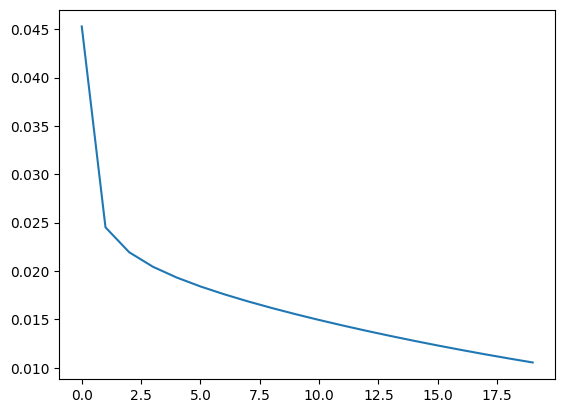

In [9]:
plt.plot(losses)
plt.show()

In [10]:
torch.save(model.state_dict(), './MLTCDataset/RCV1/model/MLP_EMB.pth')

In [11]:
from sklearn.metrics import f1_score

In [12]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
model = MLP_EMB(train_voc = train_voc)
model.load_state_dict(torch.load('./MLTCDataset/RCV1/model/MLP_EMB.pth'))
model.to(DEVICE)
next(model.parameters()).is_cuda

True

In [14]:
x, y = next(iter(testDataloader))
x, y = x.cuda(), y.cuda()

In [15]:
with torch.no_grad():
    pred = model(x)
    print(f'All (Test) mactch Acc = {torch.all((pred > 0.5).type(torch.float32) == y, dim=1).sum()/ len(y) * 100:.2f}%')
    pred_numpy = (pred > 0.5).type(torch.int32).cpu()
    y_numpy = y.cpu()
    micro_f1 = f1_score(y_true = y_numpy, y_pred = pred_numpy, average='micro')
    macro_f1 = f1_score(y_true = y_numpy, y_pred = pred_numpy, average='macro')
    print(f'Micro-F1 = {micro_f1:.2f}')
    print(f'Macro-F1 = {macro_f1:.2f}')
    

All (Test) mactch Acc = 55.08%
Micro-F1 = 0.85
Macro-F1 = 0.66


c:\Users\Wen2Tee5\Desktop\Postgraduate\torchPlayGround\torchEnv\lib\site-packages\sklearn\metrics\_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [16]:
x, y = next(iter(validDataloader))
x, y = x.cuda(), y.cuda()

In [17]:
with torch.no_grad():
    pred = model(x)
    print(f'All (Valid) mactch Acc = {torch.all((pred > 0.5).type(torch.float32) == y, dim=1).sum()/ len(y) * 100:.2f}%')
    pred_numpy = (pred > 0.5).type(torch.int32).cpu()
    y_numpy = y.cpu()
    micro_f1 = f1_score(y_true = y_numpy, y_pred = pred_numpy, average='micro')
    macro_f1 = f1_score(y_true = y_numpy, y_pred = pred_numpy, average='macro')
    print(f'Micro-F1 = {micro_f1:.2f}')
    print(f'Macro-F1 = {macro_f1:.2f}')

All (Valid) mactch Acc = 62.32%
Micro-F1 = 0.86
Macro-F1 = 0.71


c:\Users\Wen2Tee5\Desktop\Postgraduate\torchPlayGround\torchEnv\lib\site-packages\sklearn\metrics\_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [18]:
trainDataloader = DataLoader(TensorDataset(torch.from_numpy(train_x), (torch.from_numpy(train_y))), batch_size=len(train_x))

In [19]:
x, y = next(iter(trainDataloader))
x, y = x.cuda(), y.cuda()
with torch.no_grad():
    pred = model(x)
    print(f'All (Train) mactch Acc = {torch.all((pred > 0.5).type(torch.float32) == y, dim=1).sum()/ len(y) * 100:.2f}%')
    pred_numpy = (pred > 0.5).type(torch.int32).cpu()
    y_numpy = y.cpu()
    micro_f1 = f1_score(y_true = y_numpy, y_pred = pred_numpy, average='micro')
    macro_f1 = f1_score(y_true = y_numpy, y_pred = pred_numpy, average='macro')
    print(f'Micro-F1 = {micro_f1:.2f}')
    print(f'Macro-F1 = {macro_f1:.2f}')

All (Train) mactch Acc = 79.71%
Micro-F1 = 0.94
Macro-F1 = 0.88


順便測試 如果shuffle會不會影響到實驗結果 從結果推導出矩陣 row的位置是否會影響到輸出結果

In [20]:
trainDataloader = DataLoader(TensorDataset(torch.from_numpy(train_x), (torch.from_numpy(train_y))), batch_size=len(train_x), shuffle=True)

In [21]:
x, y = next(iter(trainDataloader))
x, y = x.cuda(), y.cuda()
with torch.no_grad():
    pred = model(x)
    print(f'All (Train) mactch Acc = {torch.all((pred > 0.5).type(torch.float32) == y, dim=1).sum()/ len(y) * 100:.2f}%')
    pred_numpy = (pred > 0.5).type(torch.int32).cpu()
    y_numpy = y.cpu()
    micro_f1 = f1_score(y_true = y_numpy, y_pred = pred_numpy, average='micro')
    macro_f1 = f1_score(y_true = y_numpy, y_pred = pred_numpy, average='macro')
    print(f'Micro-F1 = {micro_f1:.2f}')
    print(f'Macro-F1 = {macro_f1:.2f}')

All (Train) mactch Acc = 79.71%
Micro-F1 = 0.94
Macro-F1 = 0.88
